# Gene Set Enrichment Analysis

Gene Set Enrichment Analysis (GSEA) is an important tool in identifying key biological pathways and processes that are associated with a particular disease. The significant DEGs list obtained from the clustering analysis was analyzed using the [GSEAPY](https://gseapy.readthedocs.io/en/latest/) ```Enrichr``` module to determine the Gene Ontology (GO) and Kyoto Encyclopedia of Genes and Genomes (KEGG) pathways that were
functionally enriched.

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import anndata as ad

In [3]:
root_dir = '/Users/anhnguyen/Documents/My_Projects/ST_Data_Analysis/'
# Using the clustering results from the thesis
adata_all = ad.read_h5ad(root_dir + 'results/adata_all_UW.h5ad')

## Generate Enriched Pathways

The function below extract the significant differential expressed genes (DEGs) in each cluster with the threshold of p-value < 0.05 and |log2 fold change| > 1 (log2 fold change < -1 for down regulated genes and log2 fold change > 1 for up regulated genes).

The list of DEGs is sorted by log2 fold change and separated into down and up regulated genes. Each list is sent to GSEAPY ```Enrichr``` module with the following category:

* ```GO_Biological_Process_2023```
* ```GO_Cellular_Component_2023```
* ```GO_Molecular_Function_2023```
* ```KEGG_2019_Mouse```

All list of pathways are combined into one dataframe and saved for future used. The combined dataframe is filtered with the threshold of p-value < 0.05 to remove insignificant pathways.

In [4]:
import gseapy as gp

In [32]:
def get_pathways(adata):
    de_res = adata.uns['cluster_markers'].copy()
    de_res = de_res[(de_res['proba_not_de'] < 0.05) & (abs(de_res['lfc_mean']) > 1)]
    cats = de_res['group1'].unique()

    GO_cat = {
        'GO_Biological_Process_2023' : 'GO_BP',
        'GO_Cellular_Component_2023' : 'GO_CC',
        'GO_Molecular_Function_2023' : 'GO_MF',
        'KEGG_2019_Mouse' : 'KEGG'
    }
    frames = []
    for c in cats:
        cluster_de_res = de_res[de_res['group1'] == c]

        down_reg = cluster_de_res[cluster_de_res['lfc_mean'] < 0]
        down_reg = down_reg.sort_values(by='lfc_mean', ascending=True)
        lstdownDEGs = down_reg.index.tolist()

        up_reg = cluster_de_res[cluster_de_res['lfc_mean'] > 0]
        up_reg = up_reg.sort_values(by='lfc_mean', ascending=False)
        lstupDEGs = up_reg.index.tolist()
        
        frames_go = []
        for go in list(GO_cat.keys()):
            if len(lstdownDEGs) > 0:
                enr_down = gp.enrichr(lstdownDEGs, gene_sets=go, outdir=None)
                enr_down.res2d['Category'] = GO_cat[go]
                enr_down.res2d['UP_DW_Regulated'] = 'down'
                frames_go.append(enr_down.res2d.copy())

            if len(lstupDEGs) > 0:
                enr_up = gp.enrichr(lstupDEGs, gene_sets=go, outdir=None)
                enr_up.res2d['Category'] = GO_cat[go]
                enr_up.res2d['UP_DW_Regulated'] = 'up'
                frames_go.append(enr_up.res2d.copy())

        if len(frames_go) > 0:
            enr_res = pd.concat(frames_go)
            enr_res['cluster'] = c
            frames.append(enr_res)
    
    pathway_combined = pd.concat(frames)
    return pathway_combined

In [33]:
pathway_combined = get_pathways(adata_all)

In [35]:
pathway_combined.to_csv(root_dir + 'results/pathway_combined.csv')
pathway_combined

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Category,UP_DW_Regulated,cluster
0,GO_Biological_Process_2023,Regulation Of Epinephrine Secretion (GO:0014060),1/5,0.001749,0.013218,0,0,832.875000,5287.722500,ADRA2C,GO_BP,down,0
1,GO_Biological_Process_2023,Meiotic DNA Double-Strand Break Formation (GO:...,1/6,0.002098,0.013218,0,0,666.266667,4108.590826,SPO11,GO_BP,down,0
2,GO_Biological_Process_2023,Negative Regulation Of Catecholamine Secretion...,1/6,0.002098,0.013218,0,0,666.266667,4108.590826,ADRA2C,GO_BP,down,0
3,GO_Biological_Process_2023,Regulation Of Norepinephrine Secretion (GO:001...,1/6,0.002098,0.013218,0,0,666.266667,4108.590826,ADRA2C,GO_BP,down,0
4,GO_Biological_Process_2023,Histone Lysine Demethylation (GO:0070076),1/7,0.002448,0.013218,0,0,555.194444,3338.153583,UTY,GO_BP,down,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,KEGG_2019_Mouse,Epstein-Barr virus infection,1/229,0.963326,0.980307,0,0,0.300948,0.011244,OAS3,KEGG,up,7
153,KEGG_2019_Mouse,Thermogenesis,1/231,0.964376,0.980307,0,0,0.298301,0.010821,DPF3,KEGG,up,7
154,KEGG_2019_Mouse,Human immunodeficiency virus 1 infection,1/238,0.967819,0.980307,0,0,0.289386,0.009466,CDC25C,KEGG,up,7
155,KEGG_2019_Mouse,MicroRNAs in cancer,1/281,0.982779,0.989079,0,0,0.244404,0.004245,CDC25C,KEGG,up,7


In [36]:
significant_pathways = pathway_combined[pathway_combined['P-value'] < 0.05]
significant_pathways.reset_index(drop=True, inplace=True)
significant_pathways.to_csv(root_dir + 'results/enriched.csv')
significant_pathways

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Category,UP_DW_Regulated,cluster
0,GO_Biological_Process_2023,Regulation Of Epinephrine Secretion (GO:0014060),1/5,0.001749,0.013218,0,0,832.875000,5287.722500,ADRA2C,GO_BP,down,0
1,GO_Biological_Process_2023,Meiotic DNA Double-Strand Break Formation (GO:...,1/6,0.002098,0.013218,0,0,666.266667,4108.590826,SPO11,GO_BP,down,0
2,GO_Biological_Process_2023,Negative Regulation Of Catecholamine Secretion...,1/6,0.002098,0.013218,0,0,666.266667,4108.590826,ADRA2C,GO_BP,down,0
3,GO_Biological_Process_2023,Regulation Of Norepinephrine Secretion (GO:001...,1/6,0.002098,0.013218,0,0,666.266667,4108.590826,ADRA2C,GO_BP,down,0
4,GO_Biological_Process_2023,Histone Lysine Demethylation (GO:0070076),1/7,0.002448,0.013218,0,0,555.194444,3338.153583,UTY,GO_BP,down,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
958,KEGG_2019_Mouse,Axon guidance,6/180,0.030047,0.984845,0,0,2.666894,9.347428,EPHA5;NRP1;EFNA3;PLXNB3;LRRC4;EPHB3,KEGG,down,7
959,KEGG_2019_Mouse,Allograft rejection,3/63,0.048314,0.984845,0,0,3.843945,11.647285,H2-M5;CD80;GZMB,KEGG,down,7
960,KEGG_2019_Mouse,Cytokine-cytokine receptor interaction,13/292,0.000305,0.047889,0,0,3.329486,26.952553,IL1RN;IL18;CXCR5;CXCL17;PRLR;IL17RB;EDA2R;IL1A...,KEGG,up,7
961,KEGG_2019_Mouse,Ether lipid metabolism,3/47,0.029290,0.980096,0,0,4.756044,16.791240,PLA2G2D;GDPD3;ENPP6,KEGG,up,7


In [37]:
# Use the pathways that were generated for the thesis
significant_pathways = pd.read_csv(root_dir + 'results/enriched_thesis.csv', index_col=0)
significant_pathways.reset_index(drop=True, inplace=True)
significant_pathways

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Category,filename,UP_DW_Regulated,cluster,sample
0,GO_Biological_Process_2023,Regulation Of Epinephrine Secretion (GO:0014060),1/5,0.001749,0.013218,0,0,832.875000,5287.722500,ADRA2C,GO_BP,All_Lungs_0_down,down,0,All_Lungs
1,GO_Biological_Process_2023,Meiotic DNA Double-Strand Break Formation (GO:...,1/6,0.002098,0.013218,0,0,666.266667,4108.590826,SPO11,GO_BP,All_Lungs_0_down,down,0,All_Lungs
2,GO_Biological_Process_2023,Negative Regulation Of Catecholamine Secretion...,1/6,0.002098,0.013218,0,0,666.266667,4108.590826,ADRA2C,GO_BP,All_Lungs_0_down,down,0,All_Lungs
3,GO_Biological_Process_2023,Regulation Of Norepinephrine Secretion (GO:001...,1/6,0.002098,0.013218,0,0,666.266667,4108.590826,ADRA2C,GO_BP,All_Lungs_0_down,down,0,All_Lungs
4,GO_Biological_Process_2023,Histone Lysine Demethylation (GO:0070076),1/7,0.002448,0.013218,0,0,555.194444,3338.153583,UTY,GO_BP,All_Lungs_0_down,down,0,All_Lungs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
929,GO_Molecular_Function_2023,Phosphoric Ester Hydrolase Activity (GO:0042578),3/52,0.037920,0.499951,0,0,4.269648,13.971455,DUSP5;GDPD3;ENPP6,GO_MF,All_Lungs_7_up,up,7,All_Lungs
930,GO_Molecular_Function_2023,Protein Tyrosine/Serine/Threonine Phosphatase ...,2/23,0.042054,0.499951,0,0,6.627629,21.001643,DUSP5;DUSP2,GO_MF,All_Lungs_7_up,up,7,All_Lungs
931,KEGG_2019_Mouse,Cytokine-cytokine receptor interaction,13/292,0.000305,0.047889,0,0,3.329486,26.952553,IL1RN;IL18;CXCR5;CXCL17;PRLR;IL17RB;EDA2R;IL1A...,KEGG,All_Lungs_7_up,up,7,All_Lungs
932,KEGG_2019_Mouse,Ether lipid metabolism,3/47,0.029290,0.980096,0,0,4.756044,16.791240,PLA2G2D;GDPD3;ENPP6,KEGG,All_Lungs_7_up,up,7,All_Lungs


## Some Key Pathways

In [39]:
color_code = dict(zip(range(0, 10), plt.cm.tab10(range(0, 10))))

The top 10 significant pathways in each cluster were selected for exploratory analysis

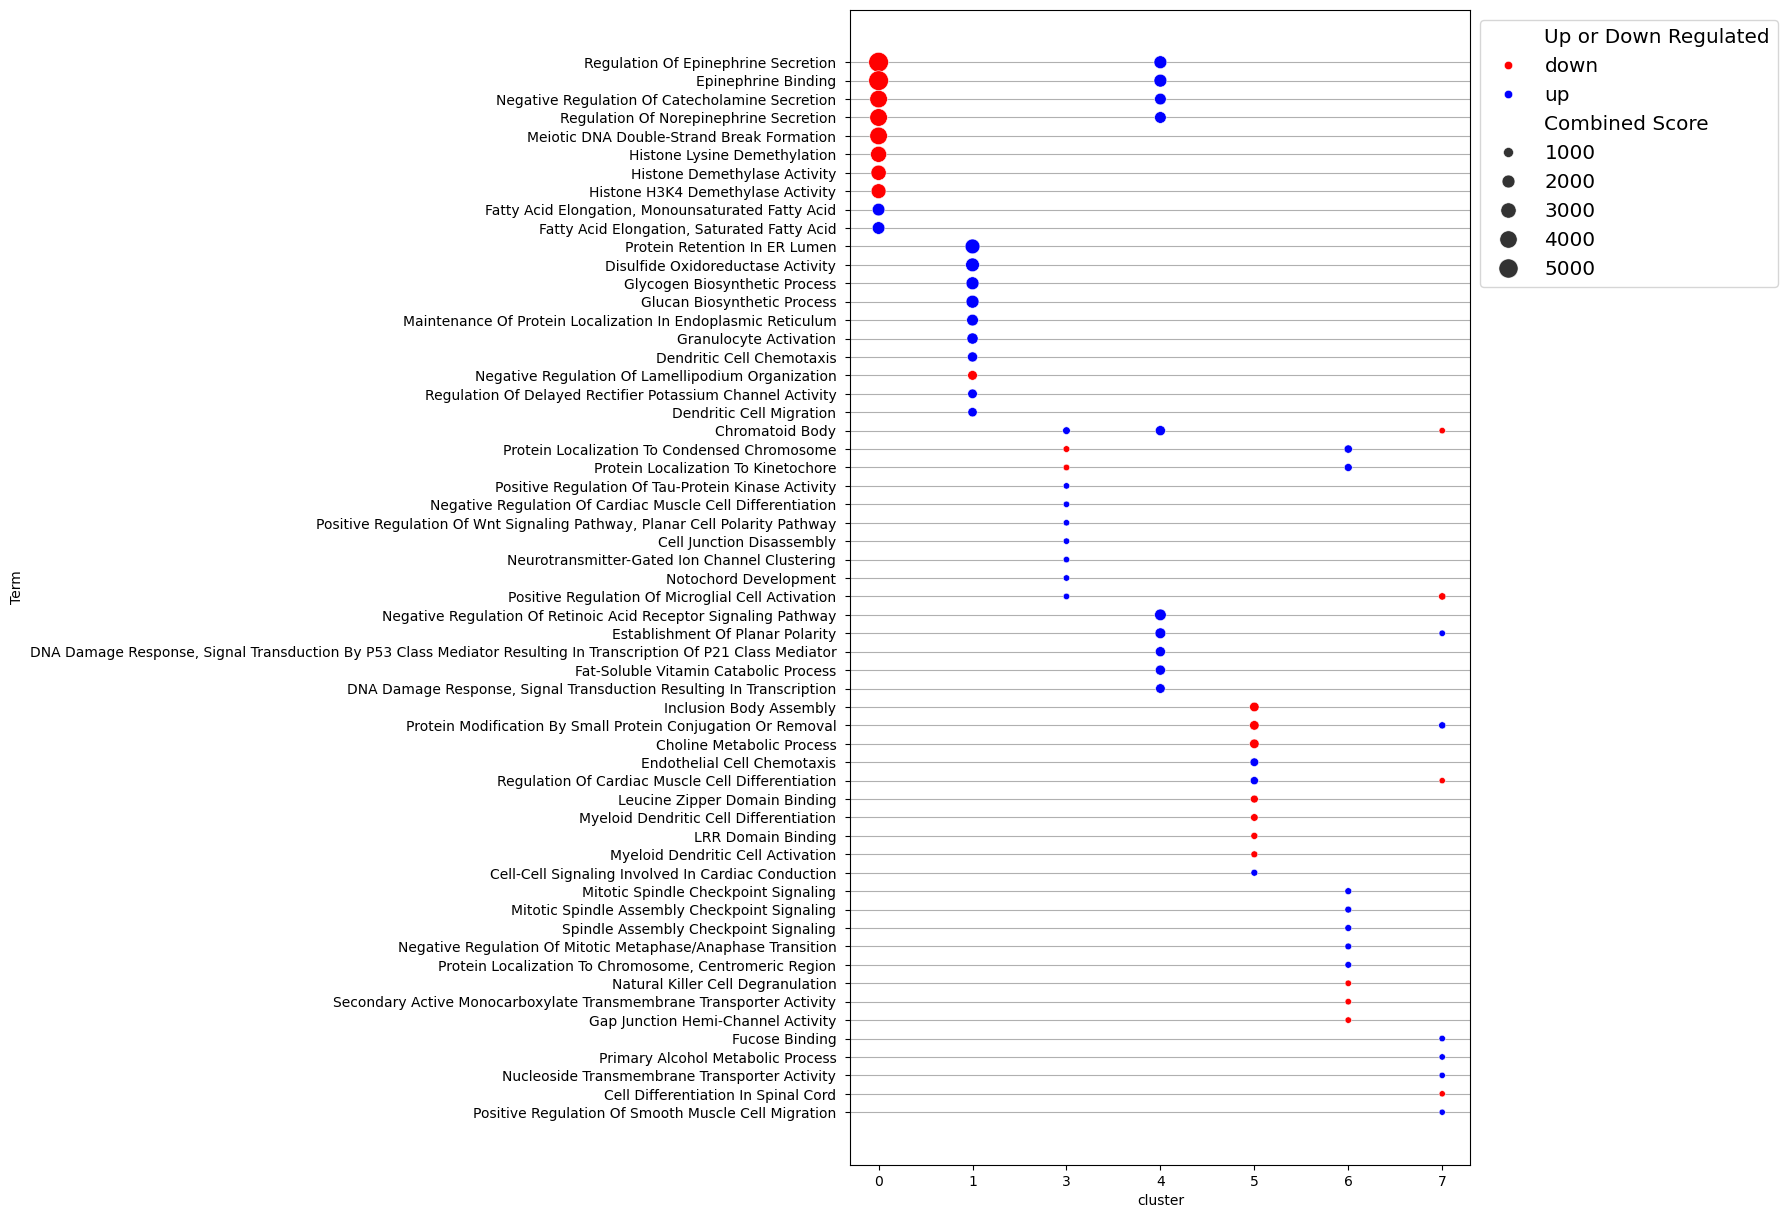

In [114]:
num_pathways = 10
index_top_pathway = []
for i in significant_pathways['cluster'].unique().tolist():
  sub_pathways = significant_pathways[significant_pathways['cluster'] == i].copy()
  sub_pathways.sort_values('Combined Score', inplace=True, ascending=False)
  top_pathways = sub_pathways.head(num_pathways).index.tolist()
  index_top_pathway.append(top_pathways)
  
flatten_index = [item for sublist in index_top_pathway for item in sublist]
plt.figure(figsize=(8,15))
color_code_UD = dict(zip(['up', 'down'], ['b', 'r']))
temp_term = significant_pathways.loc[flatten_index]['Term']
lst_sizes = significant_pathways.loc[flatten_index]['Combined Score']
ax = sns.scatterplot(x=significant_pathways.loc[flatten_index]['cluster'].astype(str),
                     y=temp_term.str.split('(').str[0],
                     size=lst_sizes,
                     sizes=(20, 200),
                     hue=significant_pathways.loc[flatten_index]['UP_DW_Regulated'],
                     palette=color_code_UD)
ax.set_axisbelow(True)
ax.grid(axis='y')

plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='x-large').get_texts()[0].set_text('Up or Down Regulated')

From the top 10 most significant pathways, we selected the pathways that had the respective DEGs involved.

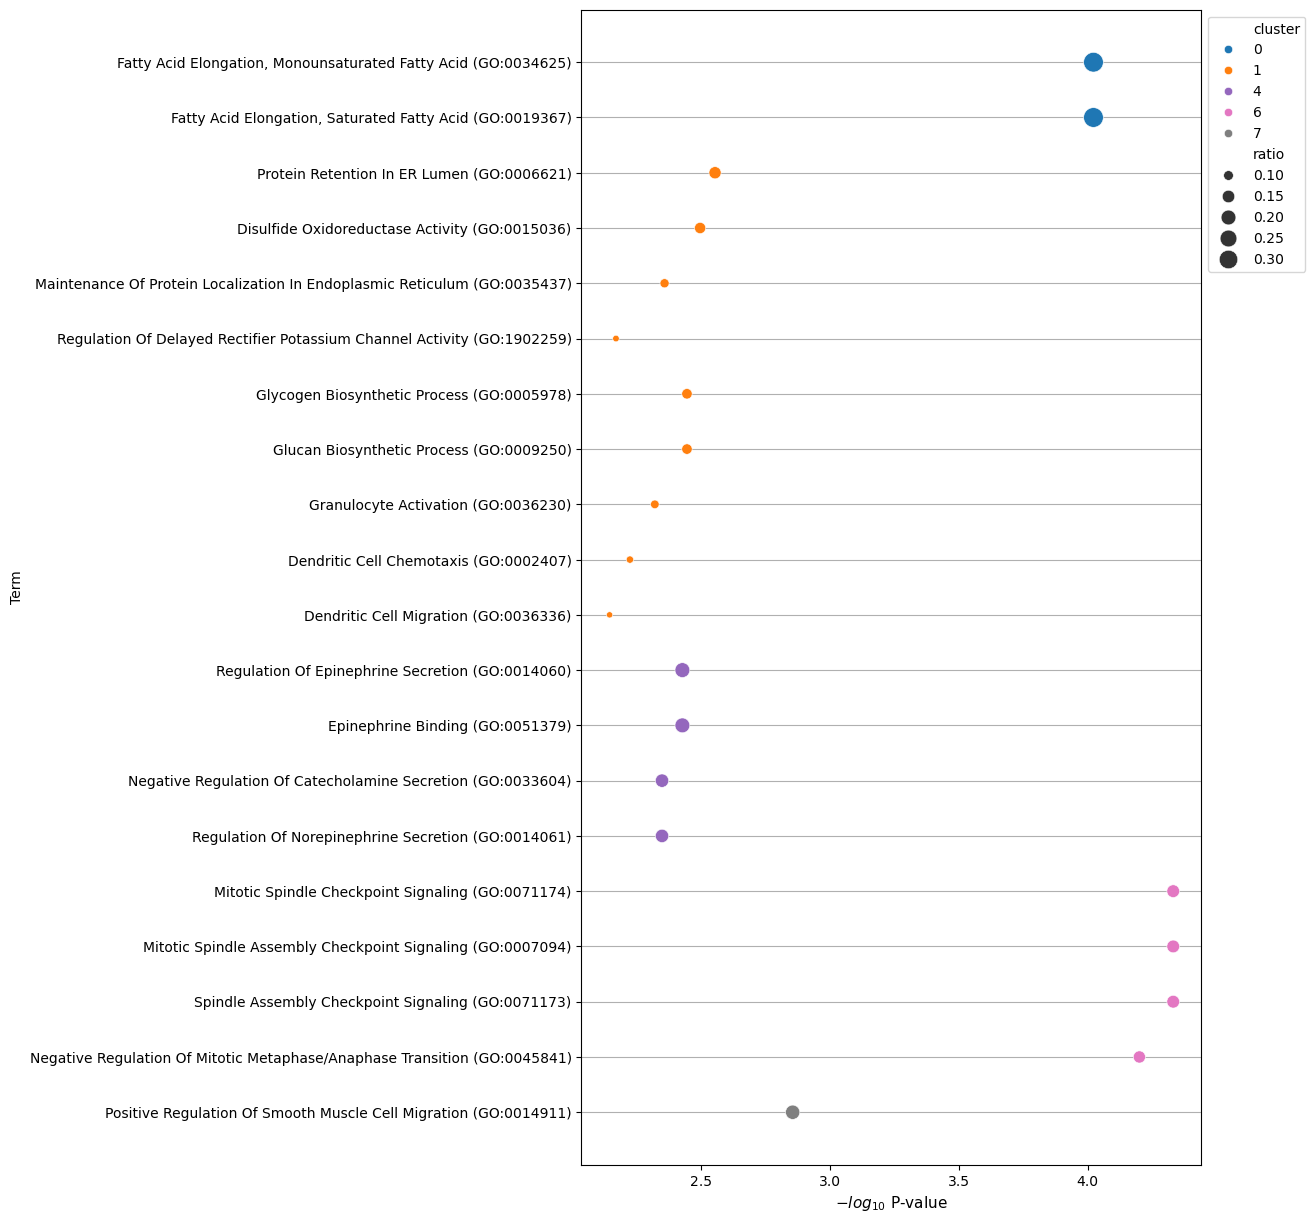

In [109]:
data = adata_all.uns['cluster_markers'].copy()
cats = adata_all.obs['clusters'].cat.categories

de_res = data[(data['proba_not_de'] < 0.05) & (data['lfc_mean'] > 1)]
de_res = de_res.sort_values(by='lfc_mean', ascending=False)

pathways_ = []
for c in cats:
  clusters_df = de_res[de_res['group1'] == c].copy()
  markers = clusters_df.index.tolist()[:10]
  sub_pathways = significant_pathways[significant_pathways['cluster'] == int(c)].copy()
  sub_pathways = sub_pathways.sort_values('Combined Score', ascending=False)
  sub_pathways = sub_pathways.head(10)
  if len(sub_pathways) > 0:
    for gene in markers:
      pathways_[len(pathways_):] = sub_pathways[sub_pathways['Genes'].str.contains(gene.upper())].index.tolist()

plt.figure(figsize=(8,15))
temp = (significant_pathways.loc[pathways_]['Overlap'].str.split('/', expand=True).astype(int))
ratio_ = temp.iloc[:, 0] / temp.iloc[:, 1]
ax = sns.scatterplot(x=-np.log10(significant_pathways.loc[pathways_]['P-value']),
                     y=significant_pathways.loc[pathways_]['Term'],
                     size=ratio_,
                     sizes=(20, 200),
                     hue=significant_pathways.loc[pathways_]['cluster'],
                     palette=color_code)
ax.set_axisbelow(True)
ax.grid(axis='y')
plt.xlabel("$-log_{10}$ P-value", size = 11)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1)).get_texts()[6].set_text('ratio')

We investigated the significant inflammatory response and macrophage-related pathways.

(0.0, 3.5)

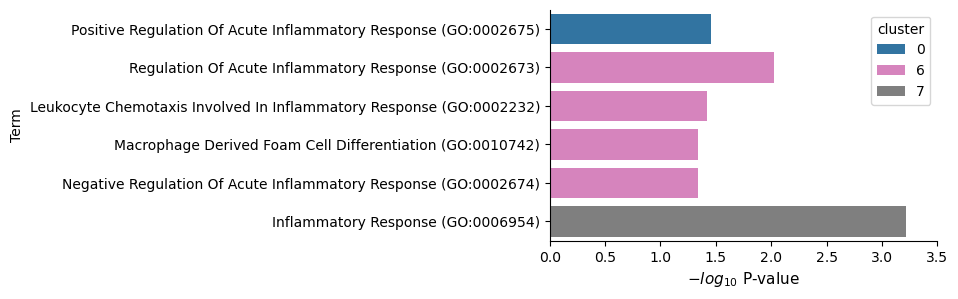

In [40]:
macro_inflam_path = significant_pathways[(significant_pathways['UP_DW_Regulated'] == 'up') &
                                          ((significant_pathways['Term'].str.contains('Macropha')) |
                                           (significant_pathways['Term'].str.contains('Inflam')))].copy()
macro_inflam_path['log10_Pvalue'] = -np.log10(macro_inflam_path['P-value'])

plt.figure(figsize=(5,3))
ax = sns.barplot(data=macro_inflam_path, x='log10_Pvalue', y='Term',
                 hue='cluster', palette=color_code, dodge=False)
plt.xlabel("$-log_{10}$ P-value", size = 11)
ax.spines[['right', 'top']].set_visible(False)
ax.set_xlim(0, 3.5)

In order to understand the role of epithelial cells in inflammatory response, we investigated all significant epithelial-related pathways and found that all of them were shown to be up-regulated in cluster 7.

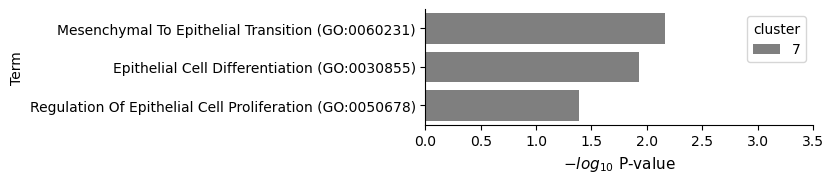

In [42]:
epithelial_path = significant_pathways[significant_pathways['Term'].str.contains('Epithelial')].copy()
epithelial_path['log10_Pvalue'] = -np.log10(epithelial_path['P-value'])

plt.figure(figsize=(5,1.5))
ax = sns.barplot(data=epithelial_path, x='log10_Pvalue', y='Term',
                 hue='cluster', palette=color_code, dodge=False)
plt.xlabel("$-log_{10}$ P-value", size = 11)
ax.set_xlim(0, 3.5)
ax.spines[['right', 'top']].set_visible(False)

We explored the endothelial cell-related pathways.

(0.0, 3.5)

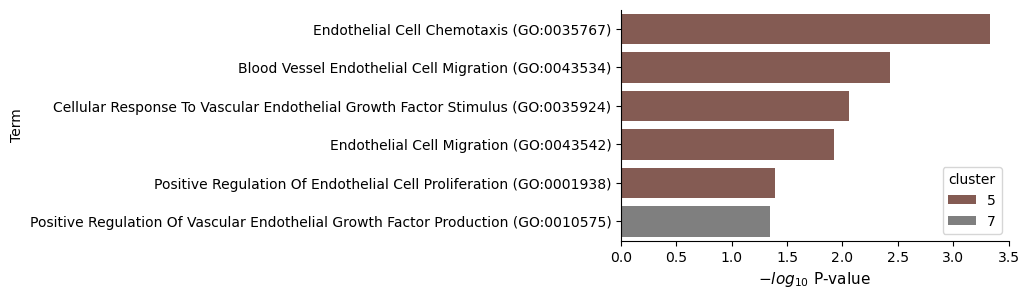

In [43]:
endothe_path = significant_pathways[significant_pathways['Term'].str.contains('Endothe')].copy()
endothe_path['log10_Pvalue'] = -np.log10(endothe_path['P-value'])

plt.figure(figsize=(5,3))
ax = sns.barplot(data=endothe_path, x='log10_Pvalue', y='Term',
                 hue='cluster', palette=color_code, dodge=False)
plt.xlabel("$-log_{10}$ P-value", size = 11)
ax.spines[['right', 'top']].set_visible(False)
ax.set_xlim(0, 3.5)